In [1]:
import numpy as np
import pickle
import os

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings


os.chdir("groupshift-model")
from groupshift_model import *

# Run single simulations

In [ ]:
# Model parameters
num_nodes = 1000
num_groups = 2
timesteps = 10000
dims = 1                # Opinion dimensions (may not work)
lowvalence = 0          # Low end of opinion values
highvalence = 100       # High end of opinion values
temp = 100              # Num active nodes per timestep
init_method = "initgauss"
ingroup_sample_size=50
outgroup_sample_size=50
# Function used for sampling method
SCOPE = AsymmetricSample(ingroup_sample_size, outgroup_sample_size, "extremity")
# Function used for Attraction effect
GLEAN = Attract(aWidth = 4.0, aAmp = 0.2)
# Function used for Repulsion effect
SHIFT = Repulse(rWidth = 4.0, rAmp = 1.0)

# Dummy values for parameters otherwise used in paralellization
simnum = 1 # This is just for filename purposes
offset_simnum= np.random.randint(10000) # This is used as the seed
foldername = "//"
G = np.array([])
N = np.array([])
N_adj = np.array([])
C = np.array([])

simulation = GroupshiftSim(G,
                           N,
                           N_adj,
                           C,
                           num_nodes,
                           dims,
                           num_groups,
                           timesteps,
                           (lowvalence, highvalence),
                           offset_simnum,
                           temp,
                           init_method,
                           SCOPE,
                           GLEAN,
                           SHIFT,
                           folder = foldername,
                           filename = f'simulation{simnum}')

In [3]:
simulation.initializeSim()
simulation.run_simulation()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [05:24<00:00, 30.80it/s]


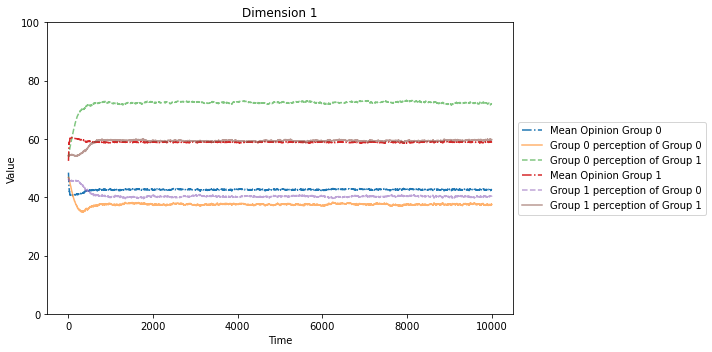

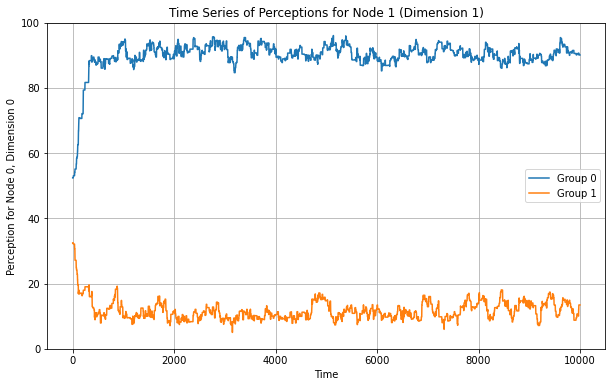

In [4]:
simulation.plot_group_values()
simulation.plot_indiv_values(0)

# Load dataset

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/l/nx/data/groupshift/simdata/results_2026_02_19_19_53.csv")
df.reset_index(drop=True, inplace=True)

In [3]:
df.head()

,simnum,init_type,sample_method,GroupID,true_mean,true_var,group_size_init,group_size_fin,percept_init,percept_fin,percept_outgroup_fin
0,915344,initgauss,extremity,0,40.761421,790.207325,482,499,45.969897,30.761307,65.150237
1,915344,initgauss,extremity,1,58.996595,730.415323,518,501,54.104183,56.650940,35.033399
2,122270,initgauss,extremity,0,40.615561,731.335733,496,493,46.171678,33.325814,67.625410
3,122270,initgauss,extremity,1,61.544813,734.474914,504,507,54.086583,63.789647,35.206458
4,770746,initgauss,random,0,42.095735,790.311143,493,544,46.106252,36.210325,60.369047


In [ ]:
import pandas as pd
import numpy as np

# -----------------------------
# Load base dataset
# -----------------------------

df = pd.read_csv("/l/nx/data/groupshift/simdata/results_2026_02_19_19_53.csv")
df.reset_index(drop=True, inplace=True)

LOW_POLE  = 0
HIGH_POLE = 100
MIDPOINT  = (LOW_POLE + HIGH_POLE) / 2

# -----------------------------
# Pole labeling (absolute)
# -----------------------------

# df["pole"] = np.where(df["true_mean"] < MIDPOINT, "low", "high")
# df["pole_sign"] = np.where(df["pole"] == "high", 1, -1)

# -----------------------------
# Pole labeling (relative)
# -----------------------------

df["rank_within_sim"] = (
    df
    .groupby(["init_type", "sample_method", "simnum"])["true_mean"]
    .rank(method="first")
)

df["pole"] = np.where(
    df["rank_within_sim"] == 1,
    "low",
    "high"
)

df["pole_sign"] = np.where(df["pole"] == "high", 1, -1)

# -----------------------------
# Signed ingroup misperception
# -----------------------------

df["signed_discrepancy"] = (
    df["pole_sign"] * (df["percept_fin"] - df["true_mean"])
)

# -----------------------------
# Reorder columns for readability
# -----------------------------

df.loc[:, ["init_type", 
           "sample_method", 
           "simnum", 
           "GroupID", 
           "group_size_init", 
           "group_size_fin", 
           "true_mean", 
           "true_var", 
           "percept_init", 
           "percept_fin", 
           "pole", 
           "pole_sign", 
           "signed_discrepancy"]
           ].head()

,init_type,sample_method,simnum,GroupID,group_size_init,group_size_fin,true_mean,true_var,percept_init,percept_fin,pole,pole_sign,signed_discrepancy
0,initgauss,extremity,915344,0,482,499,40.761421,790.207325,45.969897,30.761307,low,-1,10.000114
1,initgauss,extremity,915344,1,518,501,58.996595,730.415323,54.104183,56.650940,high,1,-2.345654
2,initgauss,extremity,122270,0,496,493,40.615561,731.335733,46.171678,33.325814,low,-1,7.289747
3,initgauss,extremity,122270,1,504,507,61.544813,734.474914,54.086583,63.789647,high,1,2.244834
4,initgauss,random,770746,0,493,544,42.095735,790.311143,46.106252,36.210325,low,-1,5.885411


# Plots
## Figure 1

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_long = df.melt(
    id_vars=["simnum", "GroupID", "sample_method"],
    value_vars=["true_mean", "percept_fin"],
    var_name="Type",
    value_name="MeanValue"
)

df_long["Type"] = df_long["Type"].map({
    "true_mean": "Real",
    "percept_fin": "Perceived"
})

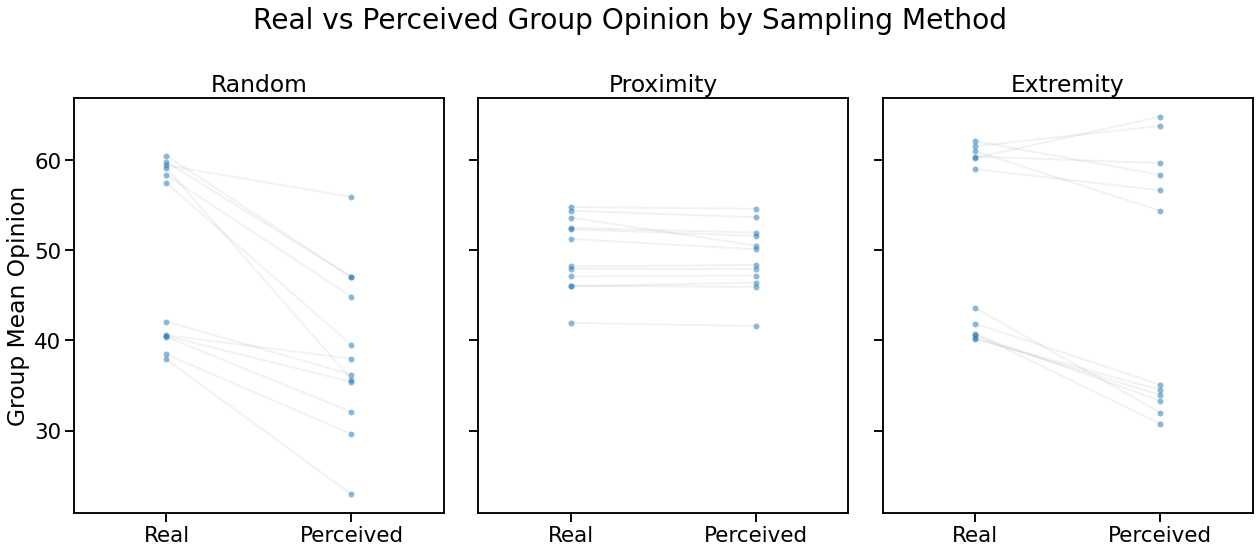

In [12]:
methods = ["random", "proximity", "extremity"]
order = ["Real", "Perceived"]

fig, axes = plt.subplots(1, len(methods), figsize=(18, 8), sharey=True)
fig.subplots_adjust(wspace=0.15)

for ax, method in zip(axes, methods):
    
    df_sub = df_long[df_long["sample_method"] == method]
    
    # Connecting lines
    for (sim, group), subdf in df_sub.groupby(["simnum", "GroupID"]):
        subdf = subdf.set_index("Type").loc[order].reset_index()
        ax.plot(
            subdf["Type"],
            subdf["MeanValue"],
            color="gray",
            alpha=0.1,
            linewidth=2
        )

    # Overlay dots
    sns.stripplot(
        data=df_sub,
        x="Type",
        y="MeanValue",
        order=order,
        jitter=0,
        alpha=0.5,
        marker=".",
        size=12,
        ax=ax
    )
    sns.set_context("talk", font_scale=1.3)

    ax.set_title(method.capitalize())
    ax.set_xlabel("")
    ax.set_ylabel("Group Mean Opinion")

plt.suptitle("Real vs Perceived Group Opinion by Sampling Method")
plt.tight_layout()

plt.savefig("figure1_v1.pdf", format="pdf", bbox_inches="tight")
plt.show()

## False polarization plot

NameError: name 'df_scatter' is not defined

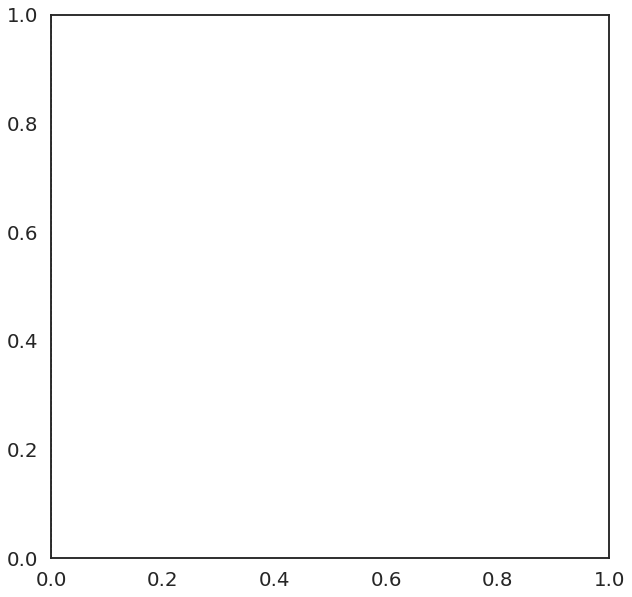

In [13]:
sns.set_context("talk", font_scale=1.2)
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10, 10))

ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.6)
ax.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.6)

sns.scatterplot(
    data=df_scatter,
    x="low_group_discrepancy",
    y="high_group_discrepancy",
    hue="sampling_method",
    style="init_type",
    alpha=0.7,
    s=60,
    palette="Set2",
    ax=ax
)

ax.set_title("False polarization vs false moderation", pad=15)
ax.set_xlabel("Signed diff (Group near 0)")
ax.set_ylabel("Signed diff (Group near 100)")

ax.set_aspect("equal", adjustable="box")

ax.legend(
    title=None,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

fig.tight_layout()
fig.subplots_adjust(right=0.8)

plt.savefig("figure_falsepol_v2.pdf", format="pdf", bbox_inches="tight")
plt.show()